# Preliminary CIFAR-10 Analysis

Simple example using CIFAR-10 and a simple fast gradient sign attack. The same code should help to analyze other data we generate.

In [2]:
%matplotlib inline
import numpy as np
import pylab as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (16,9)
from matplotlib import colors

from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
from bokeh.transform import dodge
from bokeh.models import ColumnDataSource, FactorRange, CustomJS, Range1d
from bokeh.layouts import widgetbox, column, gridplot, layout
from bokeh.models.widgets import Slider
output_notebook()

Loading BokehJS ...

In [53]:
df = pd.read_pickle(r"\\dom1\REDD\Groups\R1Q\Projects\AE_IRAD_2018\Data\Data_For_Evans_CIFAR_Experiments\January_23_more_k_values_on_wiggler\cifar10_stats_df.pkl")

print(df.dtypes.index)

datasets = pd.unique(df['Dataset'])
examples = pd.unique(df['Example#'])

print('frame has %d datasets and %d unique examples' % (len(datasets), len(examples)))
print(datasets)

Index(['boundary_distance', 'delta_loss', 'direction_id', 'direction_type',
       'k', 'y', 'y_hat', 'ell2_grad', 'Dataset', 'Example#', 'Approx_conf'],
      dtype='object')
frame has 8 datasets and 1252 unique examples
['cifar10' 'FGM-0.02' 'FGM-0.03' 'FGM-0.05' 'FGM-0.10' 'FGM-0.15'
 'FGM-0.20' 'FGM-0.25']


In [54]:
#replace infinities so we can show histograms.  Treat not finding a boundary distance as if it would take twice the distance we looked.
d_max = round(df.boundary_distance[df.boundary_distance != np.inf].max())
df.replace(np.inf, 2 * d_max, inplace=True)
print(d_max)
df.describe()

20.0


,boundary_distance,delta_loss,direction_id,k,y,y_hat,ell2_grad,Example#,Approx_conf
count,1.568276e+06,1.412868e+06,822042.000000,1.293524e+06,1.568276e+06,1.412868e+06,1.568276e+06,1.568276e+06,1.568276e+06
mean,7.661187e+00,7.023651e-01,29.415986,5.436620e+01,4.558647e+00,4.288908e+00,9.049806e-01,7.440151e+02,7.468216e+00
std,1.159442e+01,2.057901e-01,25.379454,3.312749e+01,2.912756e+00,2.783545e+00,1.882980e+00,4.301439e+02,5.060967e+00
min,6.200012e-04,-7.576848e-01,0.000000,2.000000e+00,0.000000e+00,0.000000e+00,1.030362e-13,0.000000e+00,3.786087e-04
25%,7.433815e-01,6.807370e-01,7.000000,2.000000e+01,2.000000e+00,2.000000e+00,2.971611e-04,3.740000e+02,3.373064e+00
50%,2.683985e+00,6.935483e-01,23.000000,6.000000e+01,5.000000e+00,4.000000e+00,2.340087e-02,7.460000e+02,6.745687e+00
75%,8.585157e+00,7.589674e-01,47.000000,8.000000e+01,7.000000e+00,6.000000e+00,6.188857e-01,1.113000e+03,1.092771e+01
max,4.000000e+01,1.877284e+00,99.000000,1.000000e+02,9.000000e+00,9.000000e+00,1.250695e+01,1.499000e+03,3.203421e+01


In [55]:
#Quick look at values appearing
print(df.k.value_counts())
print(df.y.value_counts())
print(df.y_hat.value_counts())

10.0     171720
100.0    162760
90.0     150240
80.0     137720
70.0     125200
60.0     112680
50.0     100160
40.0      87640
5.0       85860
30.0      75120
20.0      50080
2.0       34344
Name: k, dtype: int64
6    189490
9    180944
1    174196
3    161112
8    152664
0    152232
4    145404
5    140274
2    136354
7    135606
Name: y, dtype: int64
3.0    189378
6.0    168577
5.0    156027
4.0    155025
9.0    153220
2.0    146999
0.0    138267
1.0    137656
8.0     95163
7.0     72556
Name: y_hat, dtype: int64


# Distance to Decision Boundary
Notice already that the true examples are not uniformly distributed, but the boundary classes are more skewed.  It seems that class 6 shares more boundaries, while class 7 few.
Next, let's look at how the distance to the decision boundary is distributed

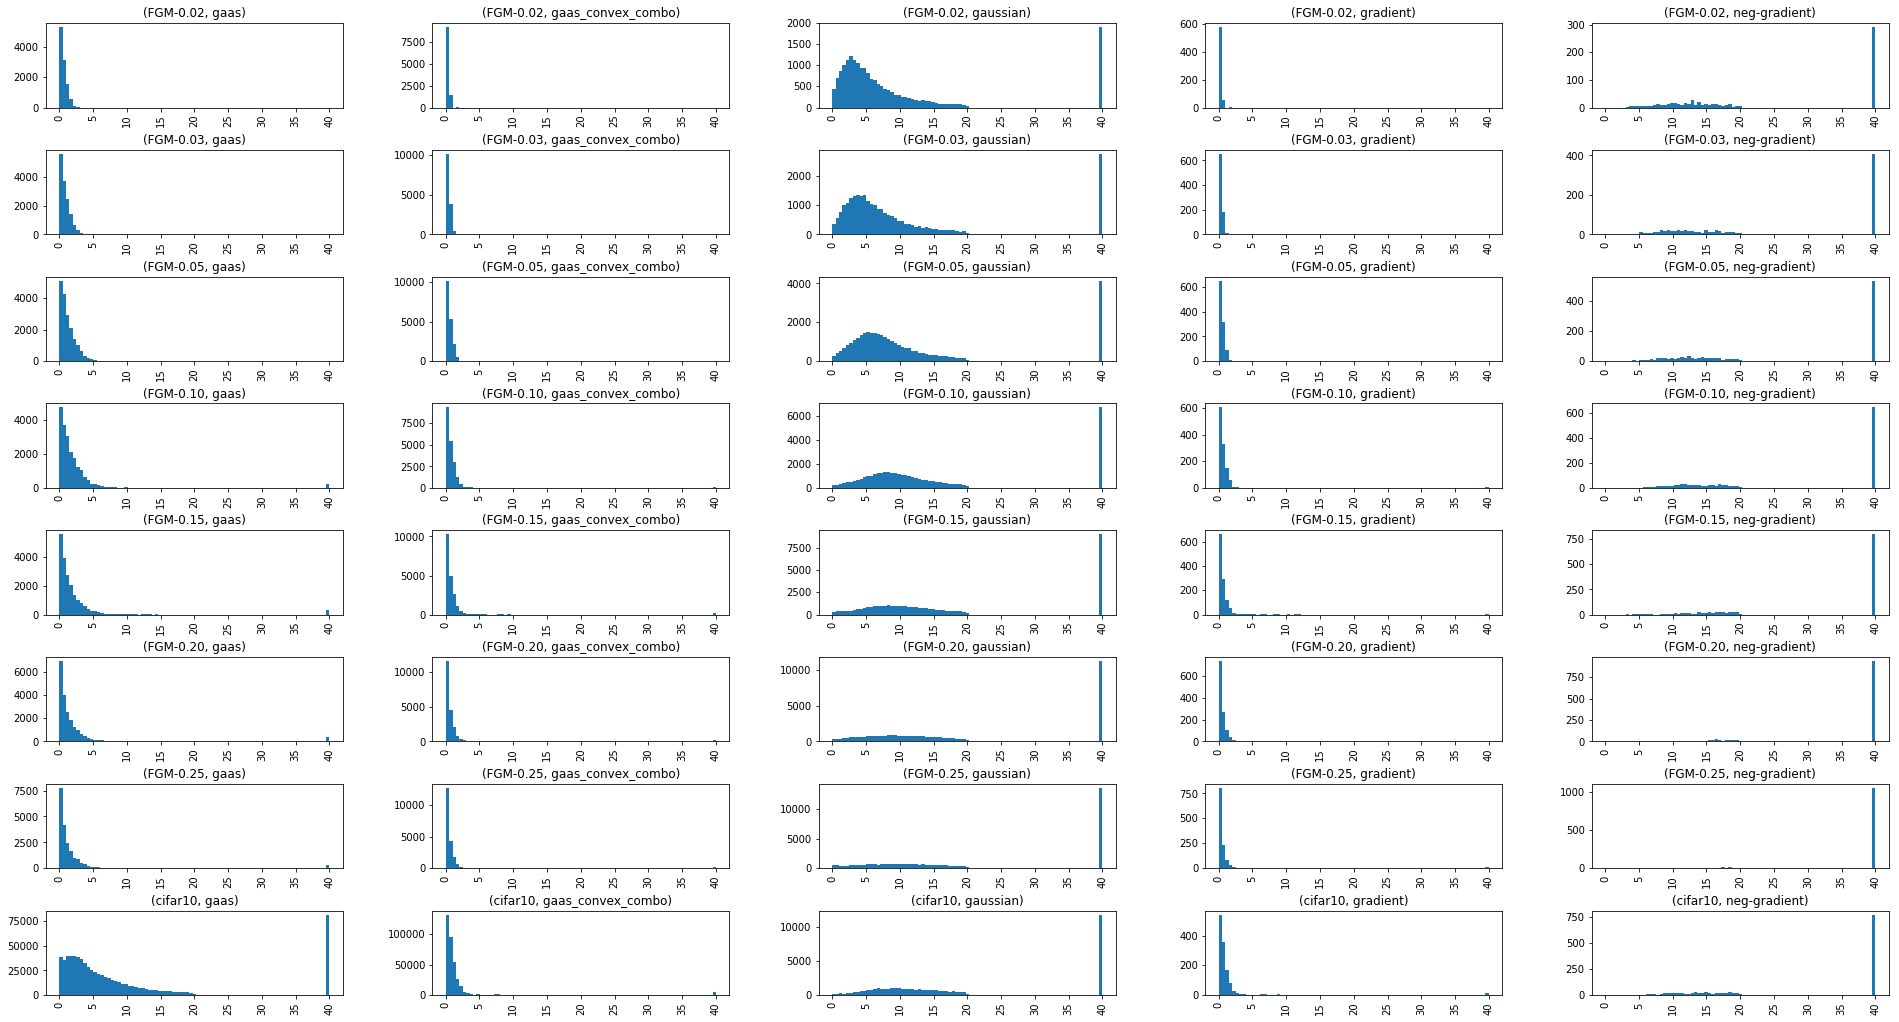

In [10]:
ax = df.hist('boundary_distance', by=['Dataset', 'direction_type'], bins=np.linspace(0,40,80), figsize=(32,18), layout=(8,5))

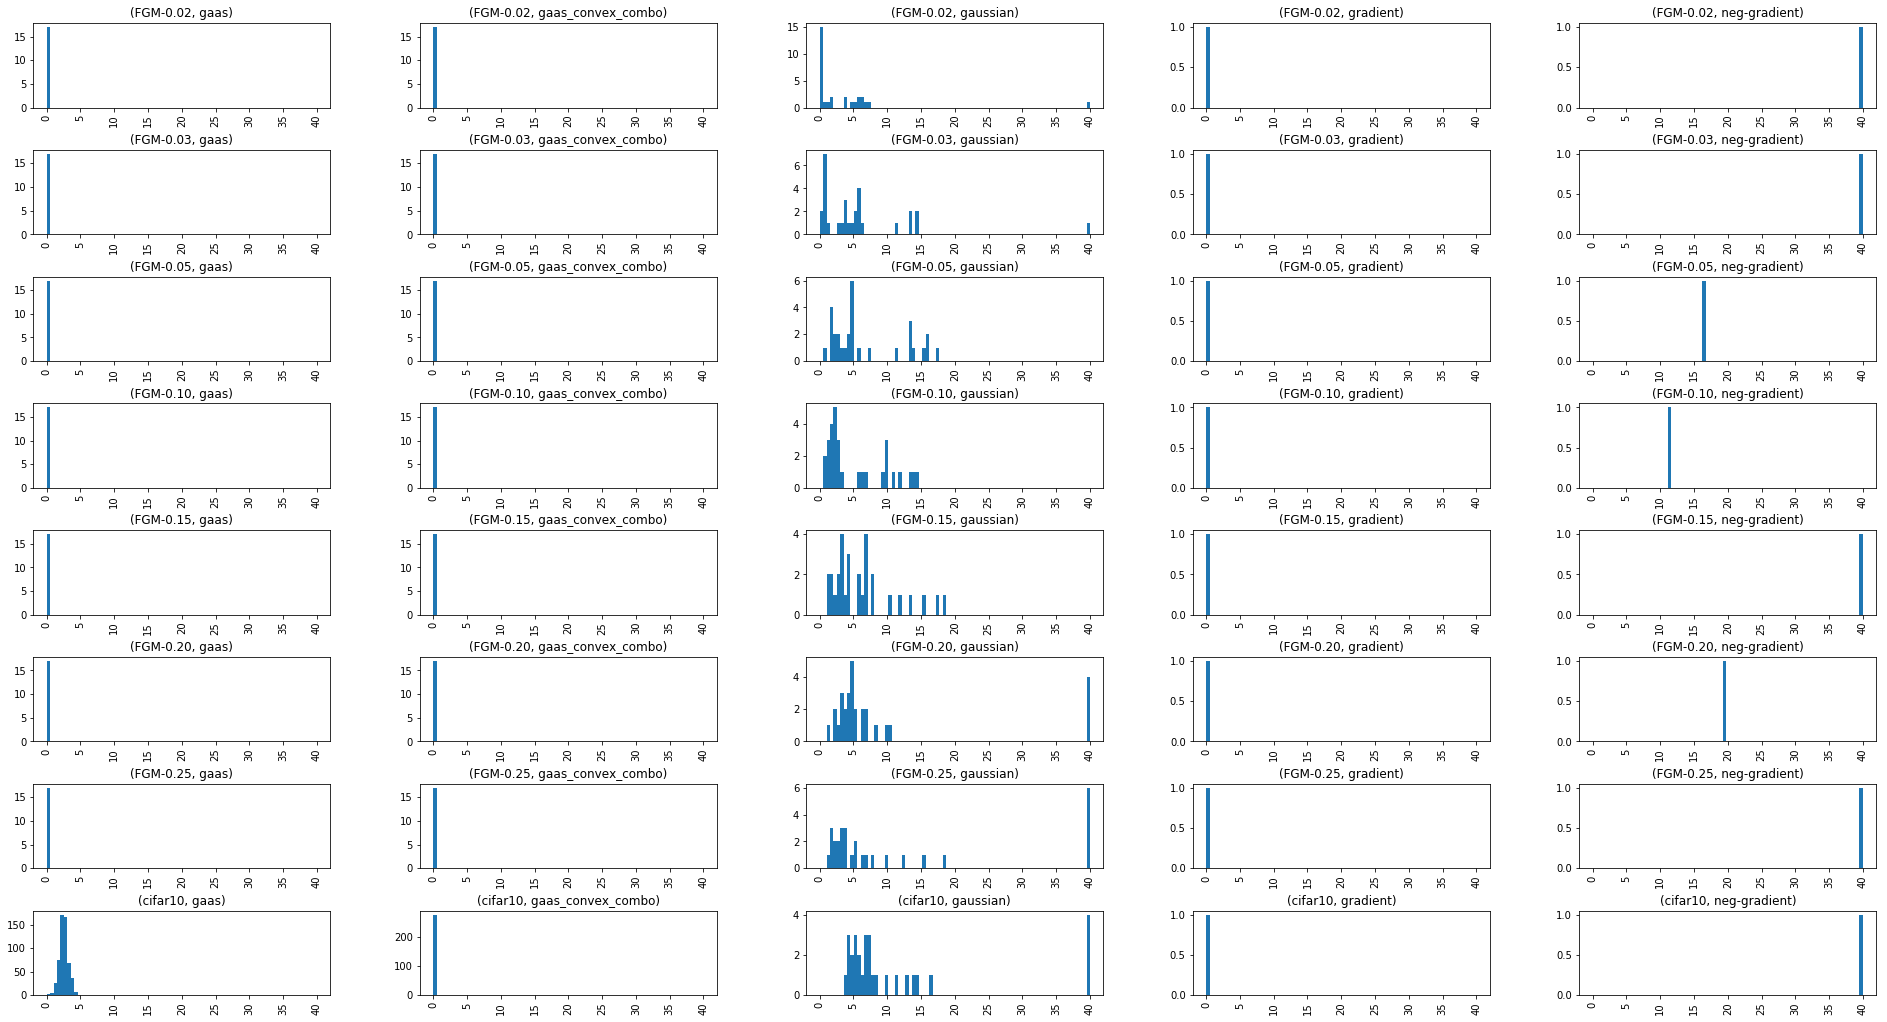

In [7]:
ax = df[df['Example#']==201].hist('boundary_distance', by=['Dataset', 'direction_type'], bins=np.linspace(0,40,80), figsize=(32,18), layout=(8,5))

In [15]:
df[df['Example#']==101]['Approx_conf'].unique()

array([ 4.61636066,  2.90108442,  5.91768169,  9.2523737 , 10.91397095,
        9.16138077,  6.70615387,  4.77800846])

In [2]:
median_bd = df[df.direction_type=='gaussian'].groupby(['Example#', 'Dataset']).boundary_distance.median()

NameError: name 'df' is not defined

In [1]:
median_bd

NameError: name 'median_bd' is not defined

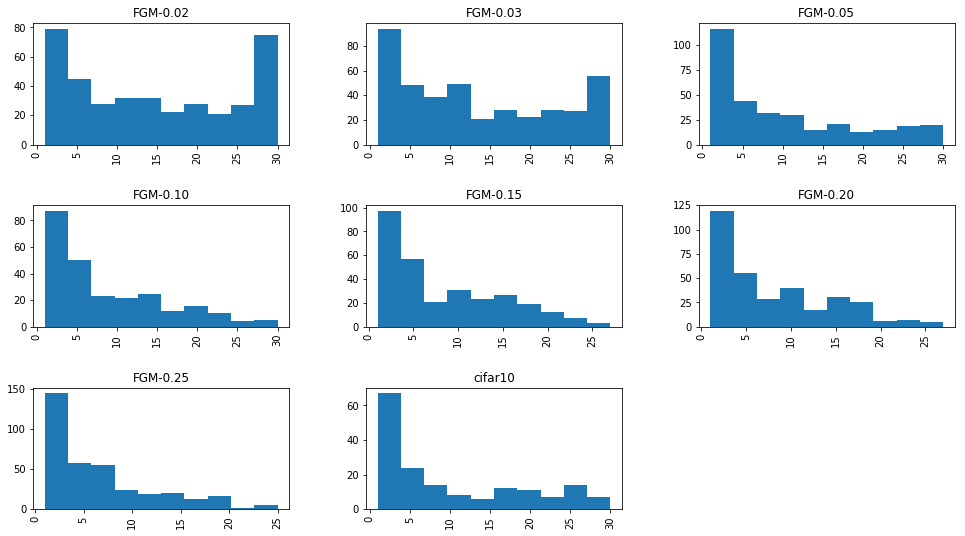

In [16]:
df[(df.direction_type=='gaussian') & (df.boundary_distance < 3)].groupby(['Example#', 'Dataset']).boundary_distance.count().hist(by='Dataset')

In [11]:
test_df = df[(df.direction_type=='gaussian')].groupby(['Example#', 'Dataset']).boundary_distance.agg(lambda x: (x<2).sum())
test_df = test_df.reset_index()
class_1 = test_df[test_df.Dataset=='FGM-0.02']
class_0 = test_df[test_df.Dataset=='cifar10']

In [17]:
FGMs = test_df.Dataset.unique()[:-1]

In [20]:
#test_df.head()
bad = test_df[(test_df.Dataset.isin(FGMs)) & (test_df.boundary_distance >0)] #this is testing the number with that boundary distance, not the distance itself
good = test_df[(test_df.Dataset=='cifar10') & (test_df.boundary_distance <1)]


AttributeError: 'numpy.ndarray' object has no attribute 'len'

In [30]:
print(len(good['Example#'].unique()))
print(len(bad['Example#'].unique()))
print(len([i for i in bad['Example#'].unique() if i in good['Example#'].unique() ]))

1157
772
733


This means that we could claim that 1157 of the 1500 examples are locally stable in the sense that none of our Gaussian perterbations of size 2 changed the class, while 773 of the AE examples had at least one boundary hit for a Gaussian perturbation size < 2.


In [32]:
bad[bad.boundary_distance == 30]

,Example#,Dataset,boundary_distance
699,120,FGM-0.02,30.0
1352,236,FGM-0.03,30.0
2390,420,FGM-0.02,30.0
3679,632,FGM-0.02,30.0
3806,653,FGM-0.02,30.0
4014,690,FGM-0.03,30.0
4015,690,FGM-0.05,30.0
4151,717,FGM-0.02,30.0
4175,721,FGM-0.03,30.0
4320,747,FGM-0.02,30.0


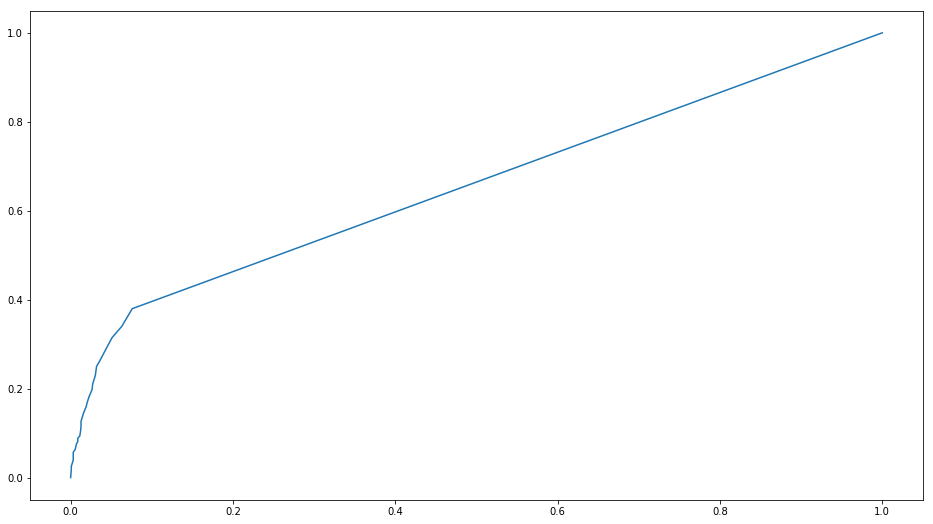

In [9]:
from sklearn.metrics import roc_curve
y_score = np.concatenate([class_0.boundary_distance, class_1.boundary_distance], axis=0)
y_true = np.concatenate([np.zeros((len(class_0),)), np.ones((len(class_1),))])
fpr, tpr, _ = roc_curve(y_true, y_score)
plt.plot(fpr, tpr)

In [60]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.6673265523695585

In [35]:
#median_bd = median_bd.reset_index()
#median_bd['median_dif_.02'] = 
print(median_bd.head(10))
bound_dists = pd.pivot(median_bd['Example#'], median_bd.Dataset, median_bd.boundary_distance)

   level_0  index  Example#   Dataset  boundary_distance
0        0      0         0  FGM-0.02           5.602951
1        1      1         0  FGM-0.03           6.541633
2        2      2         0  FGM-0.05           5.937752
3        3      3         0  FGM-0.10           5.664951
4        4      4         0  FGM-0.15           3.308947
5        5      5         0  FGM-0.20          40.000000
6        6      6         0  FGM-0.25          40.000000
7        7      7         0   cifar10           9.438899
8        8      8         1  FGM-0.02           2.923306
9        9      9         1  FGM-0.03          40.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CECCFD4F28>,
      dtype=object)

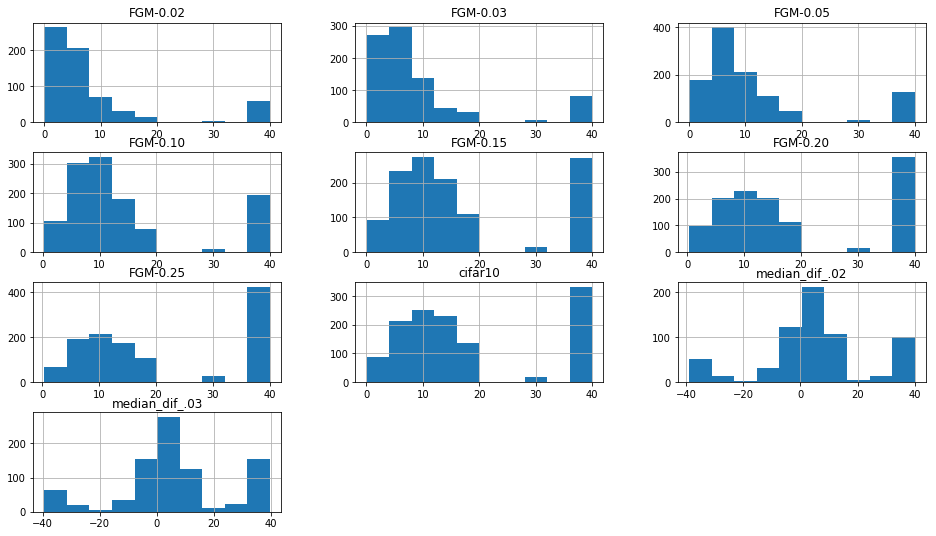

In [40]:

#bound_dists['median_dif_.03'] = bound_dists.cifar10 - bound_dists['FGM-0.03']
bound_dists.hist()

I had expected to see more of a difference in the boundary distance for regular examples (cifar10) versus the stronger FGM, but the distributions look similar.

# 'Subspace dimension'
Next, let's look focus on the gaas 'subspaces' and how well those work-- in the sense of actually creating AE directions within a reasonable distance.

In [4]:
#create subsets
k2= df[(df.k==2) & (df.direction_type=='gaas')  & (df.Dataset == 'cifar10')].groupby('Example#')
k5= df[(df.k==5) & (df.direction_type=='gaas') & (df.Dataset == 'cifar10')].groupby('Example#')
k10= df[(df.k==10) & (df.direction_type=='gaas') & (df.Dataset == 'cifar10')].groupby('Example#')

In [33]:
k100= df[(df.k==100) & (df.direction_type=='gaas') & (df.Dataset == 'cifar10')].groupby('Example#')

In [9]:
#check on 1 example
k10.boundary_distance.agg(lambda x: (x<1).sum()).value_counts() 

0.0     913
10.0    318
1.0      10
2.0       5
7.0       5
9.0       4
8.0       3
5.0       3
4.0       2
3.0       1
Name: boundary_distance, dtype: int64

In [64]:
k10.boundary_distance.head()

46    1.442743
47    1.386943
48    1.306343
49    1.355943
50    1.440263
46    1.633703
47    1.571703
48    1.646103
49    1.513423
50    1.584103
46    0.848782
47    0.825222
48    0.822742
49    0.831422
50    0.817782
46    0.383781
47    0.378821
48    0.375101
49    0.381301
50    0.381301
46    4.131068
47    4.184388
48    4.000868
49    3.672267
50    3.927708
46    0.975262
47    0.951702
48    0.952942
49    1.013702
50    1.062062
        ...   
46    1.577903
47    1.560543
48    1.612623
49    1.638663
50    1.667183
46    3.243226
47    3.235786
48    3.238266
49    3.072106
50    3.060946
46    0.259781
47    0.265981
48    0.265981
49    0.262261
50    0.270941
46    5.380991
47    5.369831
48    4.573749
49    4.841590
50    5.332631
46    6.033232
47    6.328353
48    5.705871
49    6.421353
50    6.494513
46    0.850022
47    0.822742
48    0.828942
49    0.806622
50    0.840102
Name: boundary_distance, Length: 6320, dtype: float64

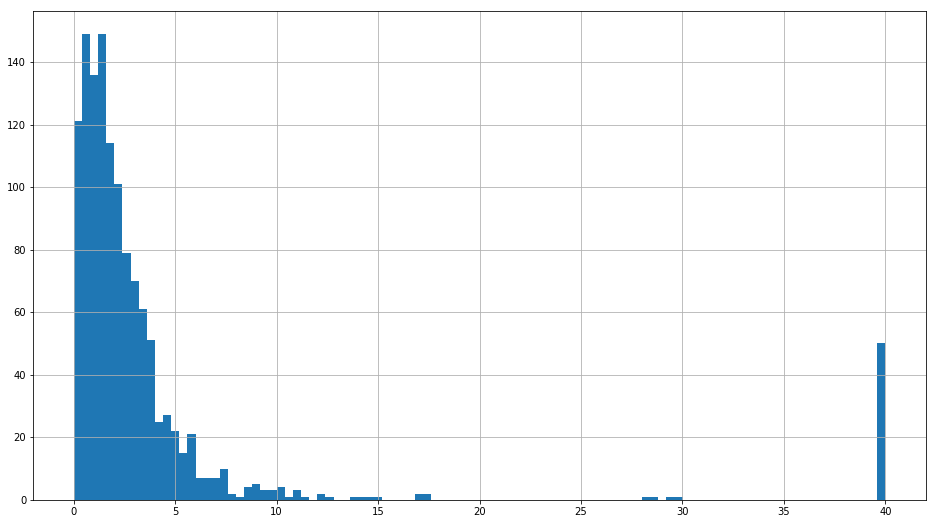

In [66]:
median_dist = k10.boundary_distance.median()
median_dist.hist(bins=100)

In [37]:
#Precalculate data using different distance thresholds.
bd_hists = {}
for d in range(81): #np.linspace(0,10,41):
    hist = np.histogram(k100.boundary_distance.agg(lambda x: (x<d/4).sum()), bins=101)
    bd_hists['_' + str(d)] = ColumnDataSource(dict(x=np.ceil(hist[1][:-1]), y=hist[0]))
source=bd_hists['_1'] #starting source for histogram

In [35]:
#This is a javascript trick to make the slider do what I want.  
steps = range(81) #np.linspace(0,10,41)
dict_of_sources = dict(zip(
                      [x for x in steps],
                      ['_%s' % x for x in steps])
                      )

js_source_array = str(dict_of_sources).replace("'", "")
#print(js_source_array)

In [38]:
p = figure(title='Histogram of successful gaas directions for k=100, different distance thresholds', y_range=(0,1300))
p.vbar(source=source, x='x', top='y', width=0.7)
p.xaxis.axis_label = "Number of AE using given boundary threshold"
p.yaxis.axis_label = "Count of samples"
#p.y_range = Range1d(0,1300)
code="""    
    var f = slider.get('value'),
        bd_hists = %s, 
        new_source = bd_hists[f].get('data');
    source.set('data', new_source);
    
""" % js_source_array

callback = CustomJS(args = bd_hists, code=code)
s1 = Slider(start=1, end=80, value=1, step=1, callback = callback, title='4 * Distance Threshold')
s1.js_on_change('value', callback)
callback.args["source"] = source
callback.args["slider"] = s1
show(column(s1, p))


Drag the slider above to try out different thresholds.  The slider is for 4 times the thresholds, i.e. intervals of 0.25 L2 distance, to get around how javascript vs python treat floats.  Even at the maximum distance we tried, 20, there are some gaas directions that fail to be adversarial.  There is still some all or nothing feel, where the vast majority of examples either have all 10 directions work or none, with only a few scattered in between.  We can now do the same thing for k=2 and k=5.

In [57]:
detection_curve = df[(df.direction_type == 'gaas') & (df['Example#']<=10) & (df.Dataset == 'cifar10')].groupby(['Example#', 'k']).boundary_distance.median()

In [70]:
dc = detection_curve.reset_index()

In [71]:
dc['Example#']

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      2
13      2
14      2
15      2
16      2
17      2
18      2
19      2
20      2
21      2
22      2
23      2
24      3
25      3
26      3
27      3
28      3
29      3
       ..
90      8
91      8
92      8
93      8
94      8
95      8
96      9
97      9
98      9
99      9
100     9
101     9
102     9
103     9
104     9
105     9
106     9
107     9
108    10
109    10
110    10
111    10
112    10
113    10
114    10
115    10
116    10
117    10
118    10
119    10
Name: Example#, Length: 120, dtype: int64

Text(0,0.5,'median boundary distance')

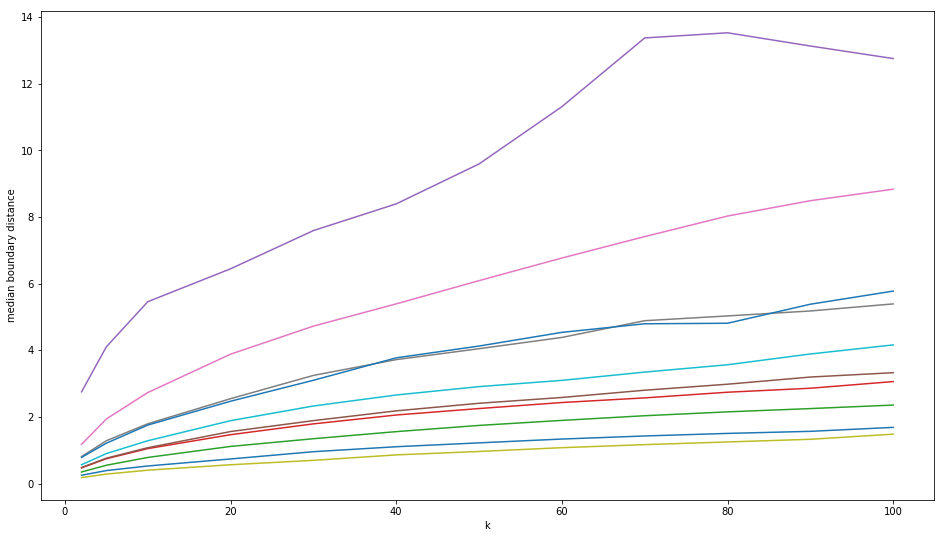

In [79]:
fig, ax = plt.subplots()
for ex in range(11):
    ax.plot(dc[dc['Example#']==ex].k, dc[dc['Example#']==ex].boundary_distance, label='Example#', )
    #detection_curve[detection_curve['Example#']==ex].plot(x='k', y='boundary_distance', label='Example#')
ax.set_xlabel('k')
ax.set_ylabel('median boundary distance')

In [83]:
dc2 = df[(df.direction_type == 'gaas') & (df['Example#'] % 101 == 0) & (df.Dataset == 'cifar10')].groupby(['Example#', 'k']).boundary_distance.median()
dc2 = dc2.reset_index()

Text(0,0.5,'median boundary distance')

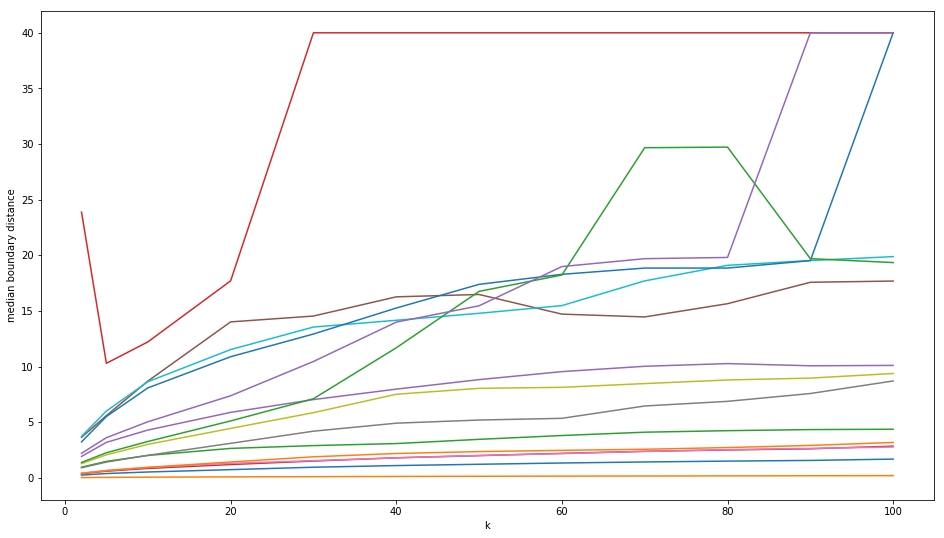

In [84]:
fig, ax = plt.subplots()
for ex in dc2['Example#'].unique():
    ax.plot(dc2[dc2['Example#']==ex].k, dc2[dc2['Example#']==ex].boundary_distance, label='Example#', )
    #detection_curve[detection_curve['Example#']==ex].plot(x='k', y='boundary_distance', label='Example#')
ax.set_xlabel('k')
ax.set_ylabel('median boundary distance')

In [13]:
#Same calculations for k=2,5.
bd_hists5 = {}
for d in range(81): #np.linspace(0,10,41):
    hist = np.histogram(k5.boundary_distance.agg(lambda x: (x<d/4).sum()), bins=6)
    bd_hists5['_' + str(d)] = ColumnDataSource(dict(x=np.ceil(hist[1][:-1]), y=hist[0]))
source5=bd_hists5['_1'] #starting source for histogram

p5 = figure(title='Histogram of successful gaas directions for k=5, different distance thresholds', y_range=(0,1600))
p5.vbar(source=source5, x='x', top='y', width=0.7)
p5.xaxis.axis_label = "Number of AE using given boundary threshold"
p5.yaxis.axis_label = "Count of samples"
#p.y_range = Range1d(0,1300)
code5="""    
    var f = slider.get('value'),
        bd_hists5 = %s, 
        new_source = bd_hists5[f].get('data');
    source5.set('data', new_source);    
""" % js_source_array

callback5 = CustomJS(args = bd_hists5, code=code5)
s5 = Slider(start=1, end=80, value=1, step=1, callback = callback5, title='4 * Distance Threshold')
#s5.js_on_change('value', callback5)
callback5.args["source5"] = source5
callback5.args["slider"] = s5

bd_hists2 = {}
for d in range(81): #np.linspace(0,10,41):
    hist = np.histogram(k2.boundary_distance.agg(lambda x: (x<d/4).sum()), bins=3)
    bd_hists2['_' + str(d)] = ColumnDataSource(dict(x=np.ceil(hist[1][:-1]), y=hist[0]))
source2=bd_hists2['_1'] #starting source for histogram

p2 = figure(title='Histogram of successful gaas directions for k=2, different distance thresholds', y_range=(0,1600))
p2.vbar(source=source2, x='x', top='y', width=0.7)
p2.xaxis.axis_label = "Number of AE using given boundary threshold"
p2.yaxis.axis_label = "Count of samples"
#p.y_range = Range1d(0,1300)
code2="""    
    var f = slider.get('value'),
        bd_hists2 = %s, 
        new_source = bd_hists2[f].get('data');
    source2.set('data', new_source);    
""" % js_source_array

callback2 = CustomJS(args = bd_hists2, code=code2)
s2 = Slider(start=1, end=80, value=1, step=1, callback = callback2, title='4 * Distance Threshold')
#s2.js_on_change('value', callback2)
callback2.args["source2"] = source2
callback2.args["slider"] = s2

show(layout([[s5, s2], [p5, p2]], responsive=True))


There's not much more interesting here.  Next, let's look at the levels of attack and different directions.  
# Average distances to boundary

In [14]:
grouped = df.groupby(['Dataset', 'direction_type'])
plot_vals = grouped.boundary_distance.mean()
plot_df = plot_vals.unstack('Dataset')
print(plot_df)

Dataset             FGM-0.02   FGM-0.03   FGM-0.05   FGM-0.10   FGM-0.15  \
direction_type                                                             
gaas                0.603573   0.839573   1.234423   2.045446   2.252860   
gaas_convex_combo   0.257226   0.356579   0.521212   0.906095   1.089959   
gaussian            9.330557  10.288678  12.241516  15.074554  17.307805   
gradient            0.225174   0.311379   0.455753   0.801129   0.974421   
neg-gradient       24.252147  25.151458  25.295892  27.870236  30.939922   

Dataset             FGM-0.20   FGM-0.25    cifar10  
direction_type                                      
gaas                1.984726   1.700062   3.440461  
gaas_convex_combo   0.960616   0.784208   1.825524  
gaussian           19.382218  21.231232  18.856182  
gradient            0.856773   0.694414   1.621754  
neg-gradient       34.554140  37.298880  29.643502  


Comparing some of this with Figure 4 from Tramer et al Subspace, we have larger distances overall (probably because cifar vs mnist), but a somewhat similar pattern (we didn't do interboundary distance or legitimate direction). 

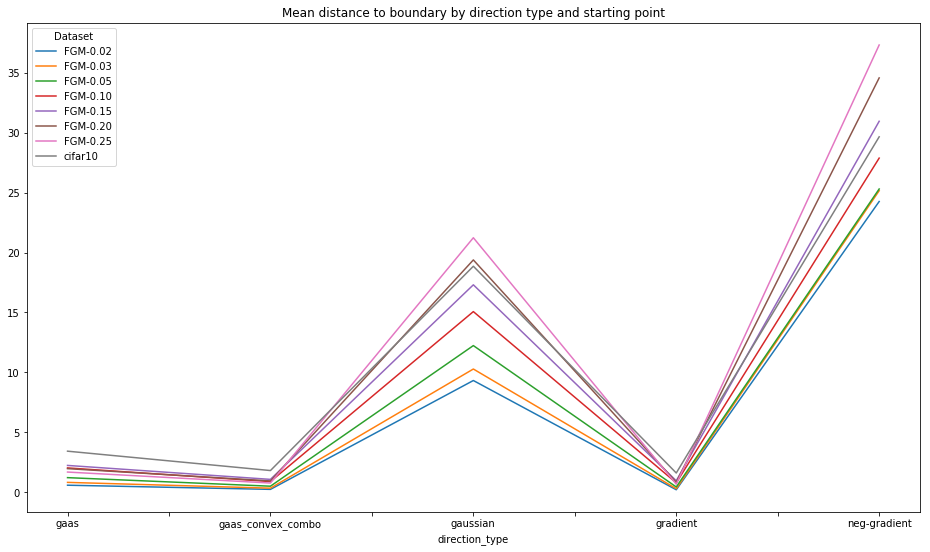

In [15]:
ax = plot_df.plot(sort_columns=['direction_type'], title='Mean distance to boundary by direction type and starting point')

Notice that the gaas_convex_combo is closer to a boundary, on par with the gradient.  This is expected, since the convex combination uses a coefficient vector with norm 1 and positive entries.  This means that the combo points in a direction 'between' the gaas directions.  The gaas directions are spread around the gradient, so the combo is closer to the gradient direction.  We might thus expect that the gaas success would decrease with k but the convex combo success would remain similar.

In [ ]:
df.hist('boundary_distance', by=['k', 'direction_type'], bins=40)

In [4]:
df.groupby(['k', 'direction_type']).boundary_distance.mean()

k     direction_type   
2.0   gaas                 1.090607
      gaas_convex_combo    0.879534
5.0   gaas                 1.611777
      gaas_convex_combo    0.904761
10.0  gaas                 2.188487
      gaas_convex_combo    0.908255
Name: boundary_distance, dtype: float64

In [6]:
df.groupby(['k', 'direction_type']).boundary_distance.median()

k     direction_type   
2.0   gaas                 0.515221
      gaas_convex_combo    0.397421
5.0   gaas                 0.814062
      gaas_convex_combo    0.414781
10.0  gaas                 1.153822
      gaas_convex_combo    0.418501
Name: boundary_distance, dtype: float64

In [8]:
print(df.boundary_distance[df.direction_type == 'gradient'].mean())
print(df.boundary_distance[df.direction_type == 'gradient'].median())

0.8017426836968126
0.36394072788145576


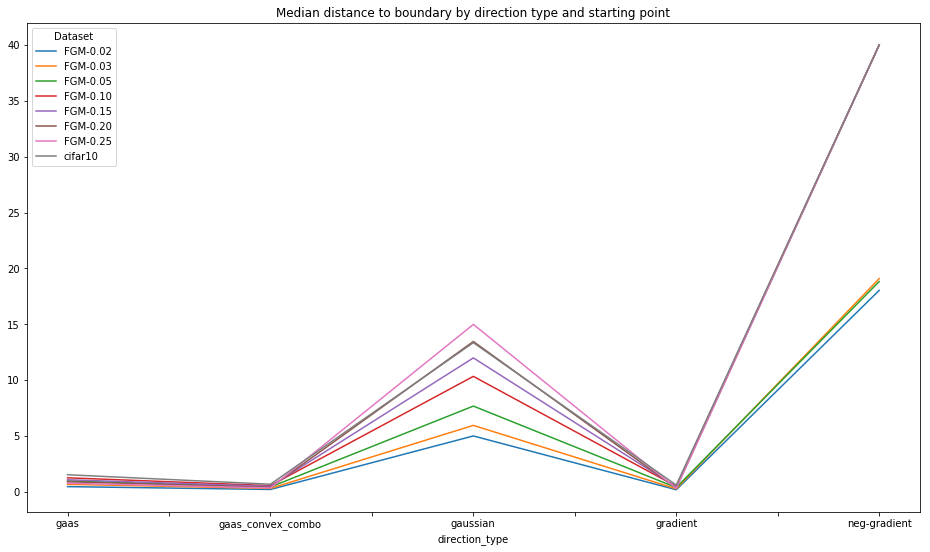

In [16]:
ax = grouped.boundary_distance.median().unstack('Dataset').plot(title='Median distance to boundary by direction type and starting point')

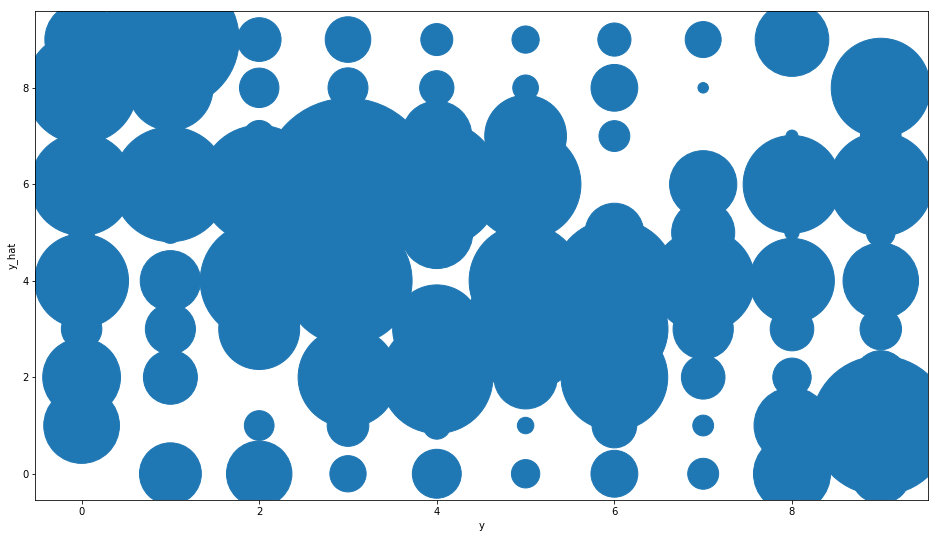

In [17]:
counts = df.groupby(['y', 'y_hat']).ell2_grad.count()
counts.reset_index().plot.scatter('y', 'y_hat', s = counts)

This plot is a little loose, but gives a sense of the starting vs ending classes, which aren't evenly distributed but don't seem to have a strong pattern. 

Next, we look at **class purity**, or the distribution of how many different ending classes were reached for a given starting example.  It's often the case that most examples reach just 2 or 3 other classes out of the 10, but unfortunately this doesn't look very different for the real vs AE starting points.

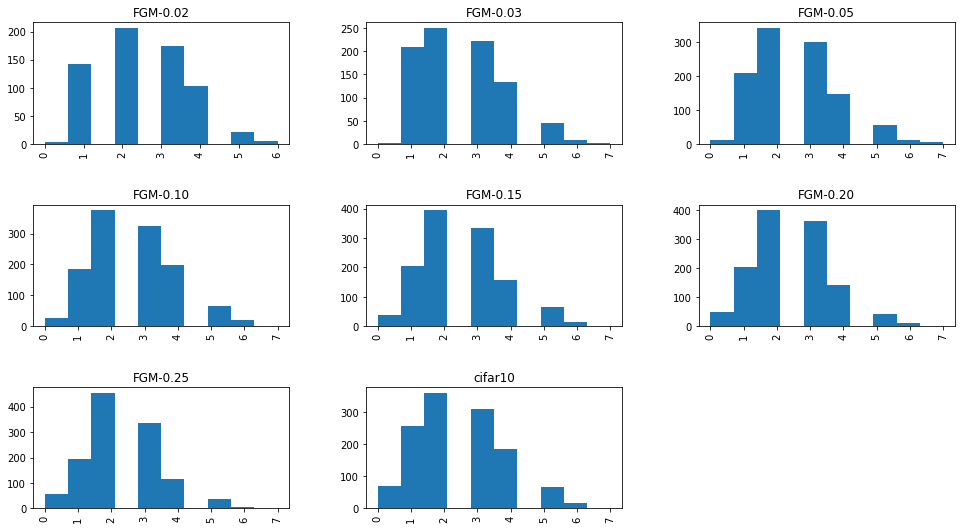

In [18]:
purity_group = df[df.direction_type == 'gaussian'].groupby(['Example#', 'Dataset'])
ax = purity_group.y_hat.nunique().hist(by='Dataset')

We're also interested in how the loss changes when we move different distances in the different directions.  This is slightly misleading, because we aren't testing various distances in each direction.  Rather, we record the distance to boundary (if we reach it).  Still, it seems worth looking at whether a greater distance is needed to produce the same loss, or creates a greater loss in order to change the class. 

To start, let's restrict to 'close' boundaries.

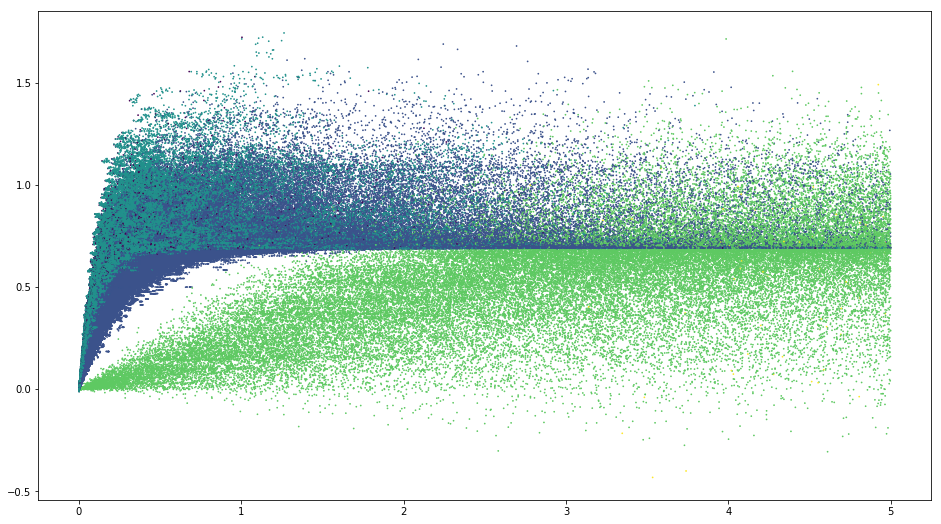

In [19]:
close = df[df.boundary_distance < 5]
type_index = {j:i for i, j in enumerate(close.direction_type.unique())}
plt.scatter(close.boundary_distance, close.delta_loss, c = close.direction_type.map(type_index), label = close.direction_type, s = 0.5)
#plt.legend()

Not that useful, though it does show a different pattern for the direction types (as we would expect).  Let's look at each separately (but combining all FGMs).

These histograms show the counts over boundary distance and change in loss.

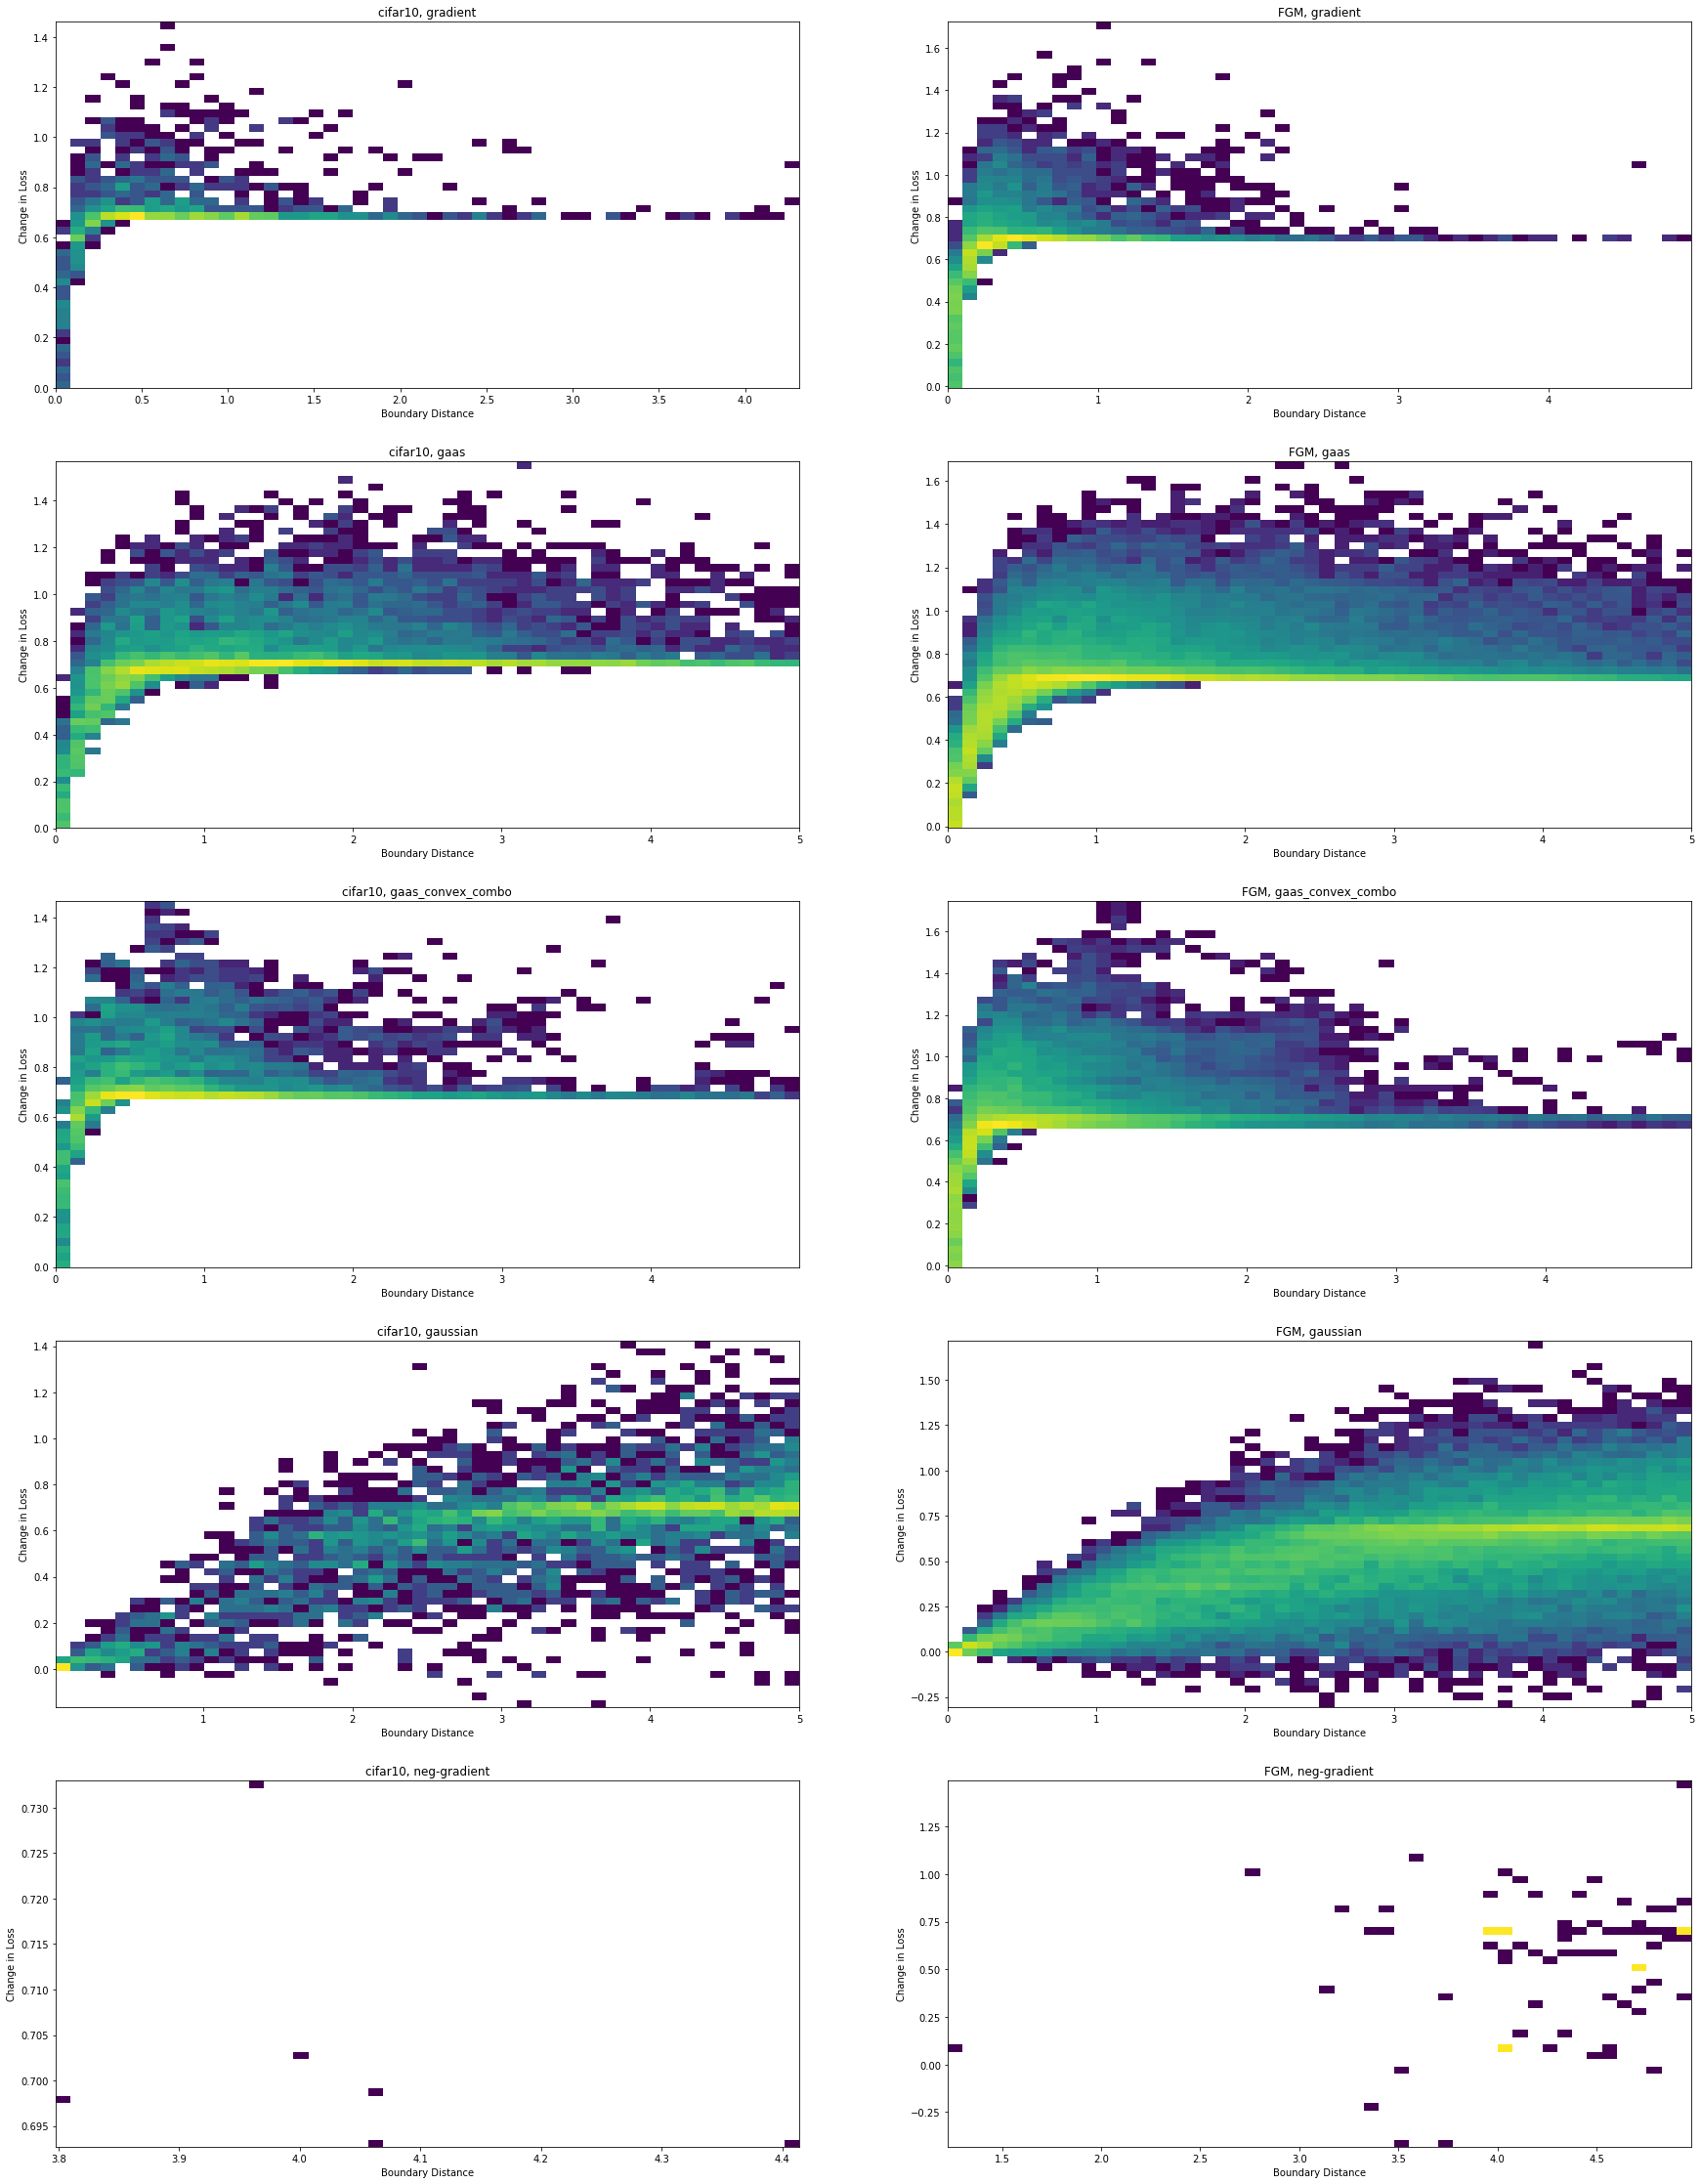

In [20]:
fig, axs = plt.subplots(5, 2,  figsize=(30,40))
for i, direction in enumerate(close.direction_type.unique()):
    axs[i,0].set_title('cifar10' + ', ' + direction)
    axs[i,0].hist2d(close[(close.direction_type == direction) & (close.Dataset == 'cifar10')].boundary_distance, close[(close.direction_type == direction) & (close.Dataset == 'cifar10')].delta_loss, bins=50, norm=colors.LogNorm())
    axs[i,0].set_xlabel('Boundary Distance')
    axs[i,0].set_ylabel('Change in Loss')
    axs[i,1].set_title('FGM' + ', ' + direction)
    axs[i,1].hist2d(close[(close.direction_type == direction) & (close.Dataset != 'cifar10')].boundary_distance, close[(close.direction_type == direction) & (close.Dataset != 'cifar10')].delta_loss, bins=50, norm=colors.LogNorm())
    axs[i,1].set_xlabel('Boundary Distance')
    axs[i,1].set_ylabel('Change in Loss')
    

Note the log-count coloring.  The random (gaussian) direction is the main one that induces negative loss while changing class.

In [21]:
df.delta_loss.describe()

count    504909.000000
mean          0.678139
std           0.228957
min          -0.647417
25%           0.627836
50%           0.692985
75%           0.766593
max           1.809731
Name: delta_loss, dtype: float64